In [1]:
import pandas as pd

# Loading the data from the Excel file
df = pd.read_excel("Online Retail.xlsx")


print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [2]:
# --- Data Cleaning ---

# Dropping rows where CustomerID is missing
df.dropna(subset=['CustomerID'], inplace=True)

# Converting CustomerID to an integer for cleaner data types
df['CustomerID'] = df['CustomerID'].astype(int)

# Removing returns (transactions with negative quantity)
df = df[df['Quantity'] > 0]

# Create the TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Converting InvoiceDate from object to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# --- Verification ---

# Displaying the data types and a summary to see our changes
print("Data Information After Cleaning:")
print(df.info())

print("\nDescriptive Statistics After Cleaning:")
print(df.describe())

Data Information After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  int64         
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.4+ MB
None

Descriptive Statistics After Cleaning:
            Quantity                    InvoiceDate      UnitPrice  \
count  397924.000000                         397924  397924.000000   
mean       13.021823  2011-07-10 23:43:36.912

In [3]:
import datetime as dt

# --- Calculate RFM Metrics ---

# Setting a snapshot date for recency calculation (one day after the last transaction)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by customer and calculate RFM values
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# Rename columns for clarity
rfm_df.rename(columns={'InvoiceDate': 'Recency',
                       'InvoiceNo': 'Frequency',
                       'TotalPrice': 'Monetary'}, inplace=True)

# --- Verification ---

# Displaying the first few rows of the new RFM dataframe
print("RFM DataFrame:")
print(rfm_df.head())

RFM DataFrame:
            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40


In [4]:
# --- RFM Segmentation ---

# Creating labels and assigning scores from 1-4 for each metric
r_labels = range(4, 0, -1) # For Recency, lower is better, so we reverse the labels
f_labels = range(1, 5)
m_labels = range(1, 5)

# Assigning scores to each customer
# Using .rank(method='first') to handle ties in Frequency
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=4, labels=r_labels)
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), q=4, labels=f_labels)
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], q=4, labels=m_labels)

# Combining scores to create a single RFM segment string
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

# --- Verification ---

# Displaying the RFM dataframe with the new scores
print("RFM DataFrame with Scores:")
print(rfm_df.head())

# To see best customers,we can filter for the top segment
print("\nOur 'Champions' (Best Customers):")
print(rfm_df[rfm_df['RFM_Segment'] == '444'].head())

RFM DataFrame with Scores:
            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Segment
CustomerID                                                                  
12346           326          1  77183.60       1       1       4         114
12347             2          7   4310.00       4       4       4         444
12348            75          4   1797.24       2       3       4         234
12349            19          1   1757.55       3       1       4         314
12350           310          1    334.40       1       1       2         112

Our 'Champions' (Best Customers):
            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Segment
CustomerID                                                                  
12347             2          7   4310.00       4       4       4         444
12362             3         10   5226.23       4       4       4         444
12388            16          6   2780.66       4       4       4         444
12417         

In [5]:
from lifetimes.utils import summary_data_from_transaction_data

# --- Prepare Data for Lifetimes ---

# Using the utility function to create the summary data
clv_summary = summary_data_from_transaction_data(
    df,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPrice'
)

# Displaying the first few rows of the new summary dataframe
print("Summary Data for CLV Modeling:")
print(clv_summary.head())

Summary Data for CLV Modeling:
            frequency  recency      T  monetary_value
CustomerID                                           
12346             0.0      0.0  325.0        0.000000
12347             6.0    365.0  367.0      599.701667
12348             3.0    283.0  358.0      301.480000
12349             0.0      0.0   18.0        0.000000
12350             0.0      0.0  310.0        0.000000


In [6]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

# --- Fitting the BG/NBD Model (to predict purchase frequency) ---
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(clv_summary['frequency'], clv_summary['recency'], clv_summary['T'])

print("BG/NBD Model Fitted successfully.")


# --- Fitting the Gamma-Gamma Model (to predict monetary value) ---
# The Gamma-Gamma model requires that frequency and monetary value are not correlated.
# We also filter for customers with at least one repeat purchase.
ggf_summary = clv_summary[clv_summary['frequency'] > 0]

ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(ggf_summary['frequency'],
        ggf_summary['monetary_value'])

print("Gamma-Gamma Model Fitted successfully.")

BG/NBD Model Fitted successfully.
Gamma-Gamma Model Fitted successfully.


In [7]:
# --- Calculating CLV ---

# Using the fitted models to predict the CLV for each customer over the next 12 months
# This function combines the outputs of both the BGF and GGF models
rfm_df['clv'] = ggf.customer_lifetime_value(
    bgf,
    clv_summary['frequency'],
    clv_summary['recency'],
    clv_summary['T'],
    clv_summary['monetary_value'],
    time=12,  # forecast period in months
    freq='D',   # frequency of T (days)
    discount_rate=0.01 # monthly discount rate
)

# --- Verification ---

# Displaying the top 10 most valuable customers based on our prediction
print("Top 10 Most Valuable Customers (Predicted CLV for next 12 months):")
print(rfm_df.sort_values(by='clv', ascending=False).head(10))

# We can also see the average predicted value for each of your RFM segments
print("\nAverage Predicted CLV by RFM Segment:")
print(rfm_df.groupby('RFM_Segment')['clv'].mean().sort_values(ascending=False))

Top 10 Most Valuable Customers (Predicted CLV for next 12 months):
            Recency  Frequency   Monetary R_Score F_Score M_Score RFM_Segment  \
CustomerID                                                                      
14646             2         74  280206.02       4       4       4         444   
18102             1         60  259657.30       4       4       4         444   
16446             1          2  168472.50       4       2       4         424   
17450             8         46  194550.79       4       4       4         444   
14096             4         17   65164.79       4       4       4         444   
14911             1        201  143825.06       4       4       4         444   
12415            24         21  124914.53       3       4       4         344   
14156            10         55  117379.63       4       4       4         444   
17511             3         31   91062.38       4       4       4         444   
16029            39         63   81024.84 

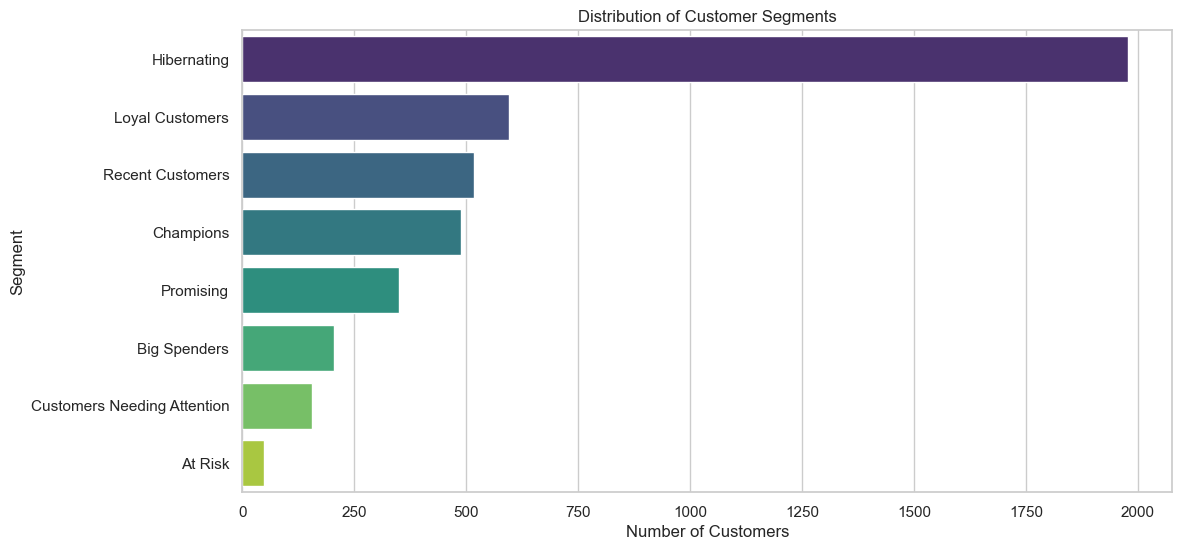

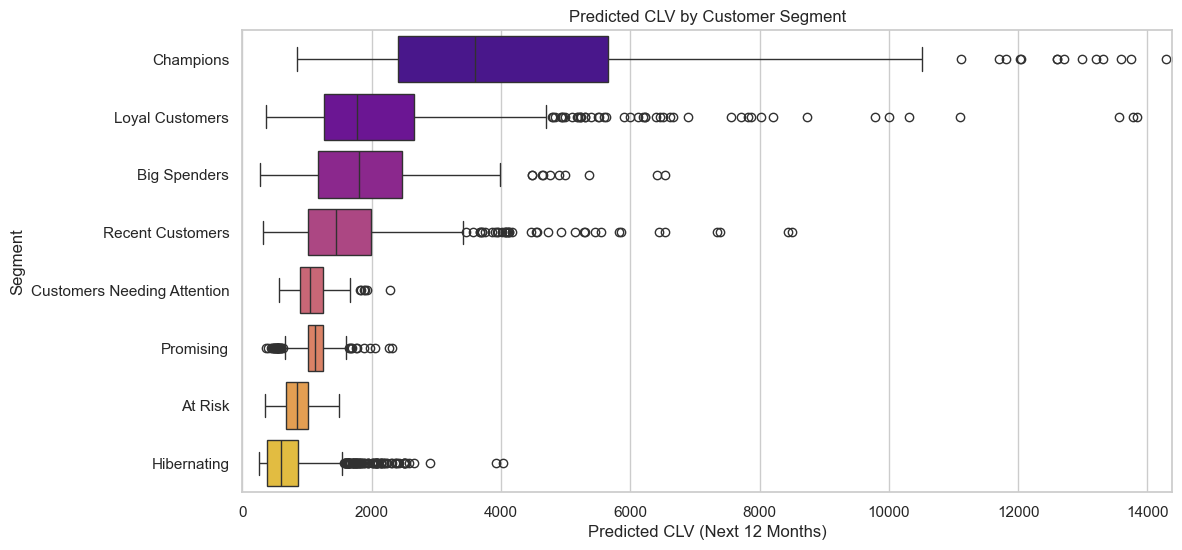

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Creating Descriptive Segment Names ---
# Defining a mapping from RFM scores to segment names
def get_segment_name(rfm_segment):
    if rfm_segment == '444':
        return 'Champions'
    elif rfm_segment[1] == '4':
        return 'Loyal Customers'
    elif rfm_segment[0] == '4':
        return 'Recent Customers'
    elif rfm_segment[2] == '4':
        return 'Big Spenders'
    elif rfm_segment in ['322', '321', '312', '311']:
        return 'Promising'
    elif rfm_segment in ['244', '243', '234', '233']:
        return 'Customers Needing Attention'
    elif rfm_segment in ['144', '143', '134', '133']:
        return 'At Risk'
    else:
        return 'Hibernating'

rfm_df['Segment_Name'] = rfm_df['RFM_Segment'].apply(get_segment_name)

# --- Visualization ---

# Setting plot style
sns.set(style="whitegrid")

# 1. Bar plot of customer segments
plt.figure(figsize=(12, 6))
sns.countplot(y='Segment_Name', data=rfm_df, order=rfm_df['Segment_Name'].value_counts().index, palette='viridis')
plt.title('Distribution of Customer Segments')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.show()

# 2. Box plot of CLV by segment
plt.figure(figsize=(12, 6))
sns.boxplot(y='Segment_Name', x='clv', data=rfm_df, order=rfm_df.groupby('Segment_Name')['clv'].mean().sort_values(ascending=False).index, palette='plasma')
plt.title('Predicted CLV by Customer Segment')
plt.xlabel('Predicted CLV (Next 12 Months)')
plt.ylabel('Segment')
plt.xlim(0, rfm_df['clv'].quantile(0.99)) # Truncate x-axis for better readability
plt.show()